# Power predictor

### First run generate_TI_set.py, which will generate the simulated TI dataset. 

In [58]:
from data_filter import get_filtered_data, prepare_turbine_seperated_data
from util import get_dataframes, timestamp_to_datetime_index, ws2ti_0
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb



### Getting filtered datasets with Simulated TI

In [59]:
data = get_filtered_data(include_ti=True, include_wse=True)
raw_data = prepare_turbine_seperated_data()

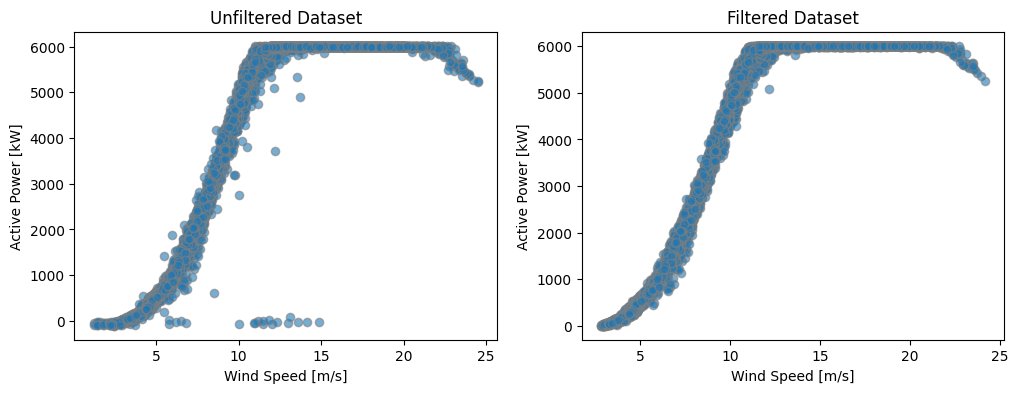

In [60]:
plt.rcParams["figure.figsize"] = (12,4)
tt = 'J04'
fig, axes = plt.subplots(1, 2)
axes[0].scatter(raw_data[tt]['WindSpeed'], raw_data[tt]['ActivePower'], edgecolor = 'gray', alpha = 0.6)
axes[1].scatter(data[tt]['WindSpeed'], data[tt]['ActivePower'], edgecolor = 'gray', alpha = 0.6)
axes[0].set_title('Unfiltered Dataset')
axes[1].set_title('Filtered Dataset')
axes[0].set_xlabel('Wind Speed [m/s]')
axes[1].set_ylabel('Active Power [kW]')
axes[1].set_xlabel('Wind Speed [m/s]')
axes[0].set_ylabel('Active Power [kW]')
plt.show()

In [61]:
print(data.keys())
print(data['A01'].columns)
print(type(data['A01']))
print(len(data['A01']))


dict_keys(['A01', 'A02', 'A03', 'A04', 'A05', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'J01', 'J02', 'J03', 'J04', 'J05', 'K01', 'K02', 'K03', 'K04', 'K05', 'L01', 'L02', 'L03', 'L04', 'L05', 'T01', 'T02', 'T03', 'T04', 'T05'])
Index(['ActivePower', 'Pitch', 'GenRPM', 'WindSpeed', 'WindDirection',
       'YawAngle', 'AirHumidity', 'AirPressure', 'AirTemp', 'TI', 'WSE', 'TSR',
       'YawOffset'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
10128


In [62]:
testdata = get_dataframes(print_names=False)
testdata['simulated_ti'].shape

(11431, 68)

### Pearson correlation.

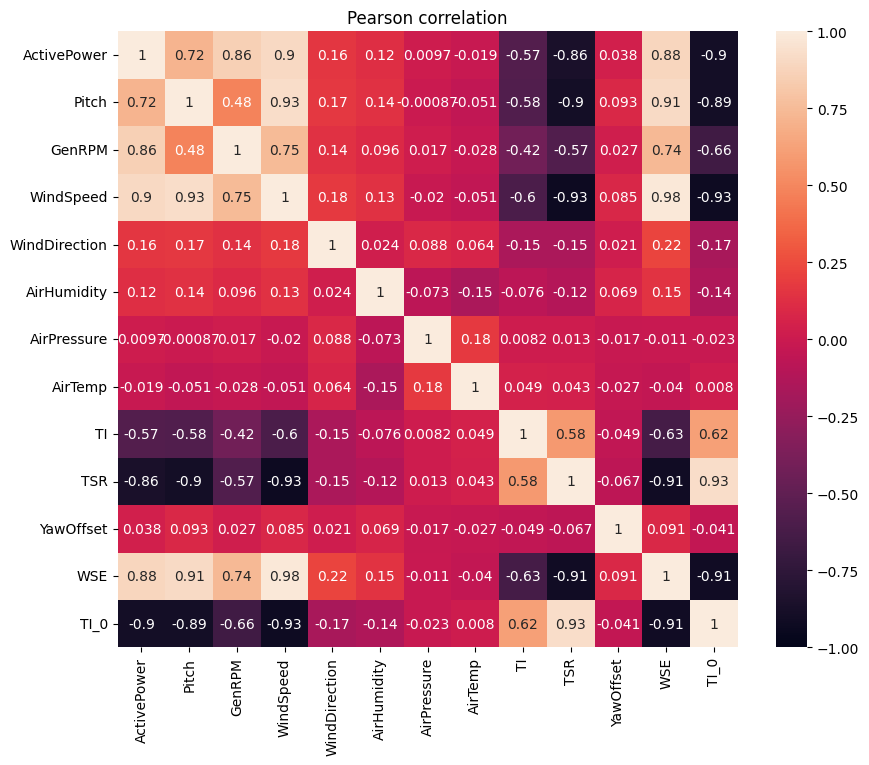

<Figure size 1500x600 with 0 Axes>

In [63]:
plt.rcParams["figure.figsize"] = (10, 8)
corrolation_sample = data['B01'][['ActivePower', 'Pitch', 'GenRPM', 'WindSpeed', 'WindDirection', 'AirHumidity', 'AirPressure', 'AirTemp', 'TI', 'TSR', 'YawOffset', 'WSE']].sample(frac=0.1)
corrolation_sample['TI_0'] = ws2ti_0(corrolation_sample['WindSpeed'])
corrolation_matrix = corrolation_sample.corr(method="pearson", numeric_only = True)

ax = sb.heatmap(corrolation_matrix, vmin = -1, vmax = 1, annot = True)
plt.figure(figsize=(15,6))
ax.set_title('Pearson correlation', )
plt.show()


### Setting WDE, WS_0 and ETI_0 as A05 mesurement for all turbines.

In [64]:
import pandas as pd

a05_wd = raw_data['A05']['WindDirection'].rename('WDE')
a05_ws = raw_data['A05']['WindSpeed'].rename('WS_0')

for name, df_i in data.items():
    df_i = pd.merge(df_i, a05_wd, on='timestamp', how='left')
    df_i = pd.merge(df_i, a05_ws, on='timestamp', how='left')
    df_i['TI_0'] = ws2ti_0(df_i['WindSpeed'])
    df_i['ETI_0'] = ws2ti_0(df_i['WS_0'])

    if df_i['WDE'].isna().sum() != 0:
        print('Problem!')
    if df_i['WS_0'].isna().sum() != 0:
        print('Problem!')
    data[name] = df_i


### XGBoost model training

In [65]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
#Dividing the training/dataset
test_data = {}
train_data = {}
for name, df_i in tqdm(data.items(), total = 67):
    train, test = train_test_split(df_i, test_size=0.2, random_state=4269)
    test_data[name] = test
    train_data[name] = train

  0%|          | 0/67 [00:00<?, ?it/s]

100%|██████████| 67/67 [00:00<00:00, 536.74it/s]


### Seeing the time split between test and train set

In [66]:
train_data['A04'].index

DatetimeIndex(['2023-10-09 03:30:00+00:00', '2023-10-22 19:20:00+00:00',
               '2023-10-24 19:30:00+00:00', '2023-11-18 20:20:00+00:00',
               '2023-10-05 09:30:00+00:00', '2023-11-17 21:50:00+00:00',
               '2023-11-19 01:50:00+00:00', '2023-12-04 05:00:00+00:00',
               '2023-10-13 21:30:00+00:00', '2023-12-07 19:40:00+00:00',
               ...
               '2023-12-30 13:50:00+00:00', '2023-10-24 15:20:00+00:00',
               '2023-10-17 13:10:00+00:00', '2023-11-05 19:30:00+00:00',
               '2023-12-31 00:30:00+00:00', '2023-12-25 20:30:00+00:00',
               '2023-12-11 11:40:00+00:00', '2023-10-05 07:40:00+00:00',
               '2023-12-23 08:00:00+00:00', '2023-10-29 05:10:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', length=8688, freq=None)

In [67]:
test_data['A04'].index

DatetimeIndex(['2023-10-17 17:10:00+00:00', '2023-10-09 05:10:00+00:00',
               '2023-12-18 22:50:00+00:00', '2023-10-05 06:40:00+00:00',
               '2023-11-15 08:40:00+00:00', '2023-11-28 14:50:00+00:00',
               '2023-11-29 08:50:00+00:00', '2023-10-06 00:40:00+00:00',
               '2023-12-20 22:20:00+00:00', '2023-12-04 06:00:00+00:00',
               ...
               '2023-11-19 01:20:00+00:00', '2023-12-01 17:10:00+00:00',
               '2023-10-25 19:10:00+00:00', '2023-12-04 05:40:00+00:00',
               '2023-12-11 08:20:00+00:00', '2023-10-15 22:40:00+00:00',
               '2023-10-13 11:50:00+00:00', '2023-12-28 15:30:00+00:00',
               '2023-11-08 14:30:00+00:00', '2023-11-23 22:20:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', length=2172, freq=None)

Generating hybrid regressors

In [68]:
from xgboost import XGBRegressor
from tqdm import tqdm
import time
hybrid_features = ['Pitch', 'WindSpeed', 'WindDirection', 'AirHumidity', 'AirPressure', 'AirTemp', 'TI', 'YawOffset', 'TSR','TI_0']
ambient_hybrid_features = ['WindSpeed', 'WindDirection', 'AirHumidity', 'AirPressure', 'AirTemp', 'TI','TI_0']
coupled_hybrid_features = ['WSE', 'WDE', 'AirHumidity', 'AirPressure', 'AirTemp', 'TI', 'ETI_0']
label = 'ActivePower'

hybrid_regressors = {}
ambient_hybrid_regressors = {}
coupled_hybrid_regressors = {}

for name, train_set in tqdm(train_data.items(), desc='Generating Hybrid Power Predictors (HPP)'):
    bst = XGBRegressor()
    abst = XGBRegressor()
    cbst = XGBRegressor()
    
    bst.fit(train_set[hybrid_features], train_set[label])
    abst.fit(train_set[ambient_hybrid_features], train_set[label])
    cbst.fit(train_set[coupled_hybrid_features], train_set[label])

    #bst.save_model(f'./regressors/hybrid/{name}_HPP.json')
    hybrid_regressors[name] = bst
    ambient_hybrid_regressors[name] = abst
    coupled_hybrid_regressors[name] = cbst


Generating Hybrid Power Predictors (HPP):   0%|          | 0/67 [00:00<?, ?it/s]

Generating Hybrid Power Predictors (HPP): 100%|██████████| 67/67 [00:14<00:00,  4.54it/s]


Generating standard regressors

In [69]:
standard_features = ['Pitch', 'WindSpeed', 'WindDirection', 'AirHumidity', 'AirPressure', 'AirTemp', 'YawOffset', 'TSR', 'TI_0'] #Only missing simulated TI
ambient_standard_features = ['WindSpeed', 'WindDirection', 'AirHumidity', 'AirPressure', 'AirTemp','TI_0']
coupled_standard_features = ['WSE', 'WDE', 'AirHumidity', 'AirPressure', 'AirTemp', 'ETI_0'] #Only missing simulated TI
solo_standard_features = ['WS_0', 'WDE', 'AirHumidity', 'AirPressure', 'AirTemp', 'ETI_0']
label = 'ActivePower'

standard_regressors = {}
ambient_standard_regressors = {}
coupled_standard_regressors = {}
solo_standard_regressors = {}

for name, train_set in tqdm(train_data.items(), desc='Generating Standard Power Predictors (SPP)'):
    bst = XGBRegressor()
    abst = XGBRegressor()
    cbst = XGBRegressor()
    sbst = XGBRegressor()

    bst.fit(train_set[standard_features], train_set[label])
    abst.fit(train_set[ambient_standard_features], train_set[label])
    cbst.fit(train_set[coupled_standard_features], train_set[label])
    sbst.fit(train_set[solo_standard_features], train_set[label])
    
    #bst.save_model(f'./regressors/standard/{name}_SPP.json')
    standard_regressors[name] = bst
    ambient_standard_regressors[name] = abst
    coupled_standard_regressors[name] = cbst
    solo_standard_regressors[name] = sbst

Generating Standard Power Predictors (SPP): 100%|██████████| 67/67 [00:16<00:00,  3.94it/s]


Getting results of test set

In [70]:
from swt6 import SWT6
from sklearn.metrics import root_mean_squared_error

standard_predictions = {}
hybrid_predictions = {}
theoretical_predictions = {}

ambient_standard_predictions = {}
ambient_hybrid_predictions = {}

coupled_standard_predictions = {}
coupled_hybrid_predictions = {}
solo_standard_predictions = {}

estimated_standard_predictions = {}
estimated_hybrid_predictions = {}
estimated_theoretical_predictions = {}

for name, test_df in test_data.items():
        hres = hybrid_regressors[name].predict(test_df[hybrid_features])
        sres = standard_regressors[name].predict(test_df[standard_features])
        tres = SWT6.power_ct(test_df['WindSpeed'].to_numpy())[0]/1000 # because in W and not kW

        ahres = ambient_hybrid_regressors[name].predict(test_df[ambient_hybrid_features])
        asres = ambient_standard_regressors[name].predict(test_df[ambient_standard_features])

        ehres = ambient_hybrid_regressors[name].predict(test_df[coupled_hybrid_features].rename(columns={'WSE':'WindSpeed', 'WDE':'WindDirection','ETI_0':'TI_0'}))
        esres = ambient_standard_regressors[name].predict(test_df[coupled_standard_features].rename(columns={'WSE':'WindSpeed', 'WDE':'WindDirection', 'ETI_0':'TI_0'}))
        etres = SWT6.power_ct(test_df['WSE'].to_numpy())[0]/1000 # because in W and not kW

        chres = coupled_hybrid_regressors[name].predict(test_df[coupled_hybrid_features])
        csres = coupled_standard_regressors[name].predict(test_df[coupled_standard_features])
        ssres = solo_standard_regressors[name].predict(test_df[solo_standard_features])

        standard_predictions[name] = sres
        hybrid_predictions[name] = hres
        theoretical_predictions[name] = tres
        ambient_standard_predictions[name] = asres
        ambient_hybrid_predictions[name] = ahres
        
        estimated_standard_predictions[name] = esres
        estimated_hybrid_predictions[name] = ehres
        estimated_theoretical_predictions[name] = etres

        coupled_standard_predictions[name] = csres
        coupled_hybrid_predictions[name] = chres
        solo_standard_predictions[name] = ssres
        
        



In [71]:

rmse_standard = {}
rmse_hybrid = {}
rmse_theoretical = {}

rmse_a_standard = {}
rmse_a_hybrid = {}

rmse_e_standard = {}
rmse_e_hybrid = {}
rmse_e_theoretical = {}

rmse_c_standard = {}
rmse_c_hybrid = {}
rmse_s_standard = {}

for name, test_df in test_data.items():
    if name in ['A03', 'A05', 'F01', 'K01', 'L03', 'T03']:
        continue
    rmse_hybrid[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=hybrid_predictions[name])
    rmse_standard[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=standard_predictions[name])
    rmse_theoretical[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=theoretical_predictions[name])
    rmse_a_standard[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=ambient_standard_predictions[name])
    rmse_a_hybrid[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=ambient_hybrid_predictions[name])
    
    rmse_c_standard[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=coupled_standard_predictions[name])
    rmse_c_hybrid[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=coupled_hybrid_predictions[name])
    rmse_s_standard[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=solo_standard_predictions[name])

    rmse_e_standard[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=estimated_standard_predictions[name])
    rmse_e_hybrid[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=estimated_hybrid_predictions[name])
    rmse_e_theoretical[name] = root_mean_squared_error(y_true=test_df[label].to_numpy(), y_pred=estimated_theoretical_predictions[name])


this plot was aided by chatgpt

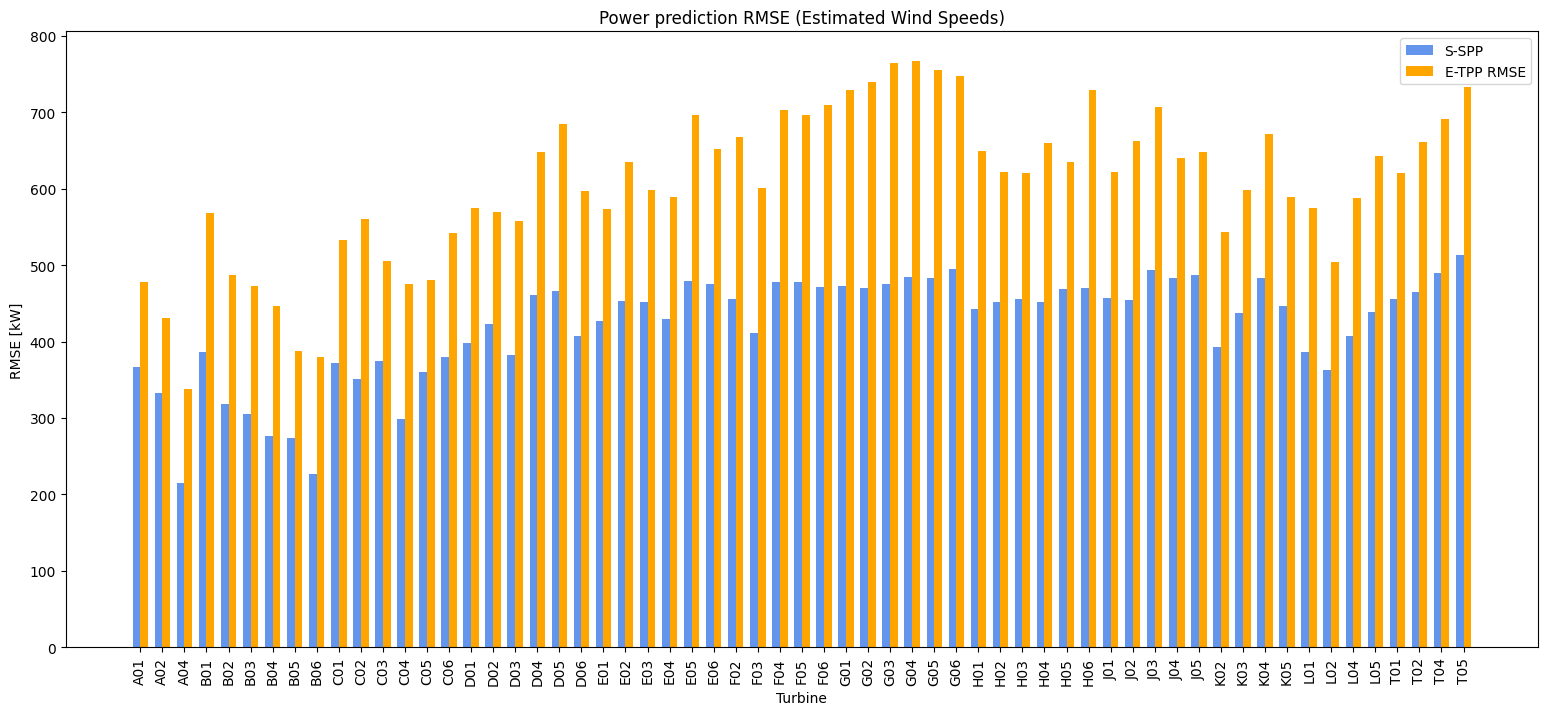

In [72]:
plt.rcParams["figure.figsize"] = (19, 8)

# Extract keys and values
keys = list(rmse_hybrid.keys())
values1 = list(rmse_s_standard.values())
values2 = list(rmse_e_theoretical.values())

# Define positions for the bars
bar_width = 0.35
index = np.arange(len(keys))

# Create the bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(index, values1, bar_width, label='S-SPP', color='cornflowerblue')
bar2 = ax.bar(index + bar_width, values2, bar_width, label='E-TPP RMSE', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Turbine')
ax.set_ylabel('RMSE [kW]')
ax.set_title('Power prediction RMSE (Estimated Wind Speeds)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(keys)
plt.xticks(rotation=90)
ax.legend()

# Display the chart
plt.show()

### To exclude:
A03, A05, F01, K01, L03, T03
### These turbine sets are inspected:

In [73]:
from data_filter import prepare_turbine_seperated_data
raw_data = prepare_turbine_seperated_data()


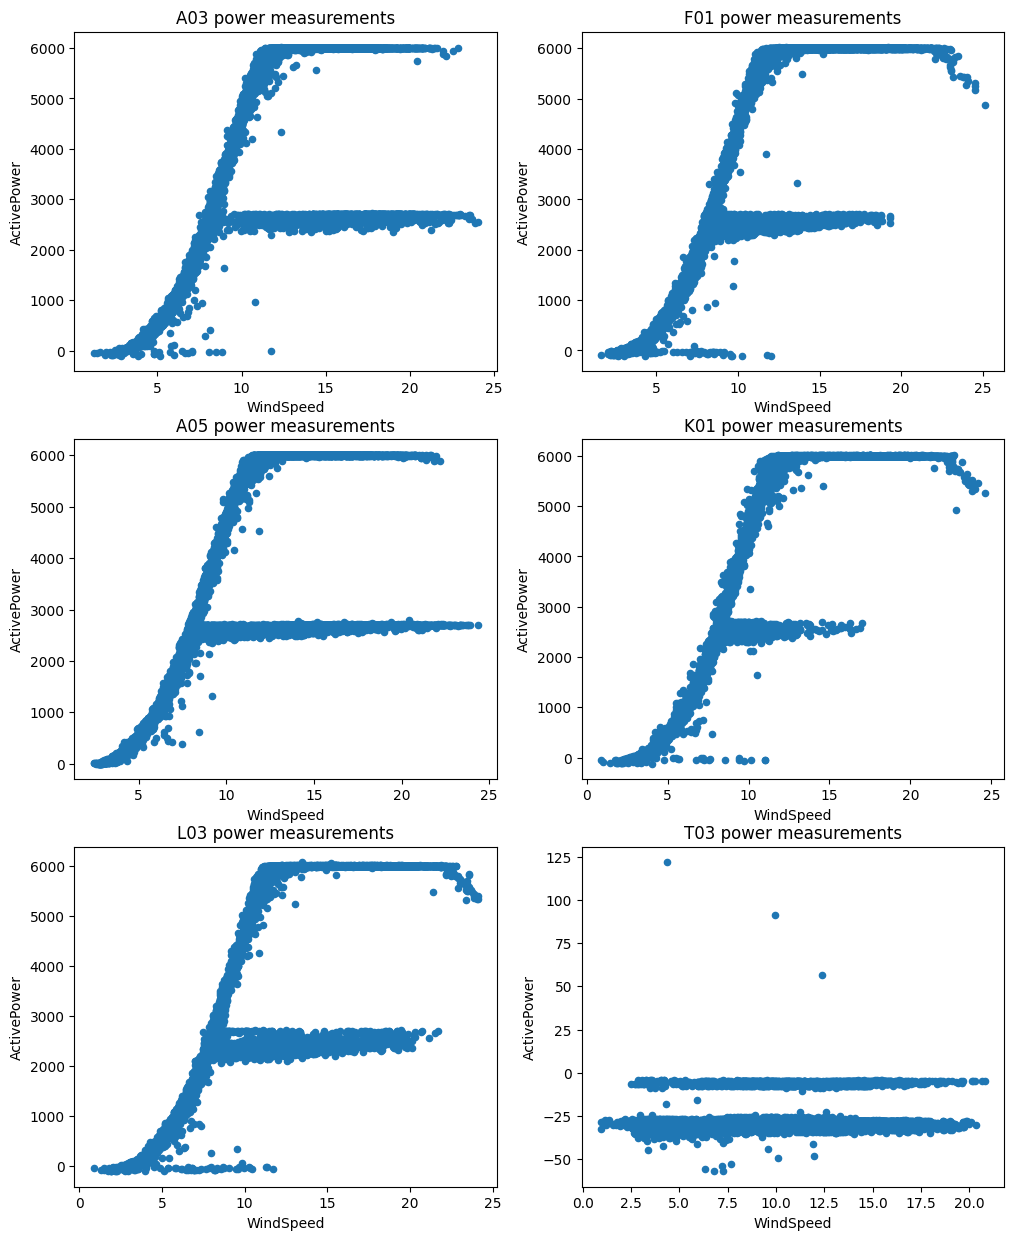

In [74]:
plt.rcParams["figure.figsize"] = (12, 15)

fig, axs = plt.subplots(3, 2)
raw_data['A03'].plot.scatter(x='WindSpeed', y='ActivePower', ax= axs[0,0])
raw_data['A05'].plot.scatter(x='WindSpeed', y='ActivePower', ax= axs[1,0])
raw_data['F01'].plot.scatter(x='WindSpeed', y='ActivePower', ax= axs[0,1])
raw_data['K01'].plot.scatter(x='WindSpeed', y='ActivePower', ax= axs[1,1])
raw_data['L03'].plot.scatter(x='WindSpeed', y='ActivePower', ax= axs[2,0])
raw_data['T03'].plot.scatter(x='WindSpeed', y='ActivePower', ax= axs[2,1])



axs[0,0].set_title('A03 power measurements')
axs[1,0].set_title('A05 power measurements')
axs[0,1].set_title('F01 power measurements')
axs[1,1].set_title('K01 power measurements')
axs[2,0].set_title('L03 power measurements')
axs[2,1].set_title('T03 power measurements')

plt.show()

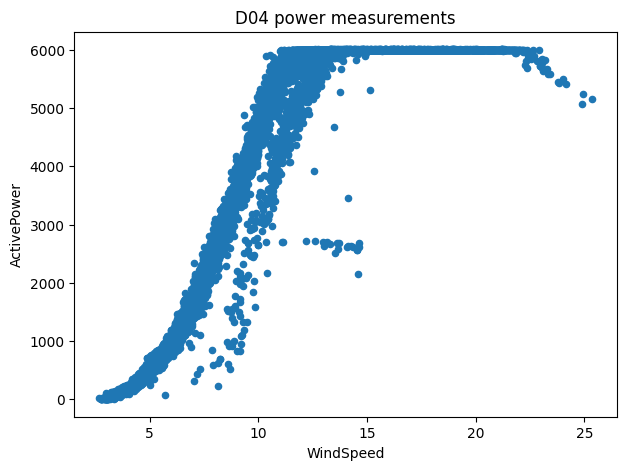

In [75]:
import pandas as pd
plt.rcParams["figure.figsize"] = (7, 5)
data['D04'].plot.scatter(x='WindSpeed', y='ActivePower')
plt.title('D04 power measurements')
plt.show()


### Plotting average RMSE

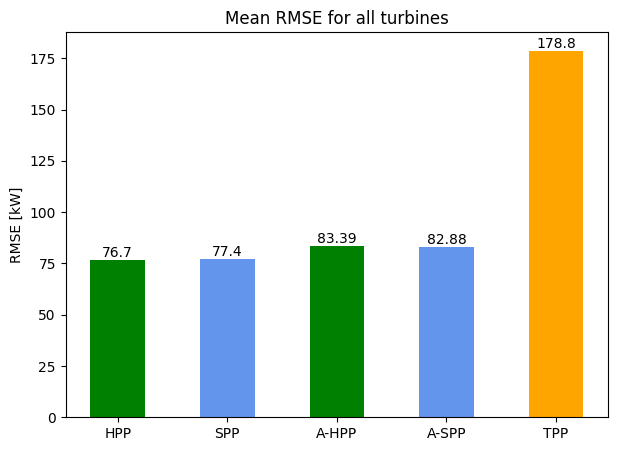

In [76]:
theo_rmse_mean = pd.DataFrame(rmse_theoretical, index=[0]).mean(axis=1)[0]
hybrid_rmse_mean = pd.DataFrame(rmse_hybrid, index=[0]).mean(axis=1)[0]
standard_rmse_mean = pd.DataFrame(rmse_standard, index=[0]).mean(axis=1)[0]
ambient_hybrid_rmse_mean = pd.DataFrame(rmse_a_hybrid, index=[0]).mean(axis=1)[0]
ambient_standard_rmse_mean = pd.DataFrame(rmse_a_standard, index=[0]).mean(axis=1)[0]


labels = ['HPP', 'SPP', 'A-HPP', 'A-SPP', 'TPP']
values = [hybrid_rmse_mean, standard_rmse_mean, ambient_hybrid_rmse_mean, ambient_standard_rmse_mean, theo_rmse_mean]
colors = ['green', 'cornflowerblue', 'green', 'cornflowerblue', 'orange']

bars = plt.bar(labels, values, width=0.5, color=colors)

plt.title('Mean RMSE for all turbines')

plt.ylabel('RMSE [kW]')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom', 
             fontsize=10, color='black', ha='center') 



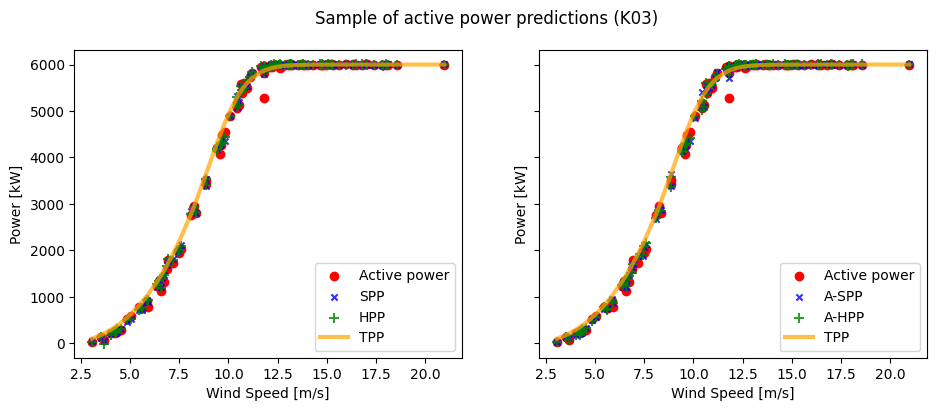

In [77]:
plt.rcParams["figure.figsize"] = (11, 4)
tt = 'K03'
topn = 100
ws = test_data[tt]['WindSpeed'].head(topn)
labels = test_data[tt][label].head(topn)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].scatter(ws, labels, color = 'red', label='Active power')
axs[0].scatter(ws, standard_predictions[tt][:topn], marker='x', color = 'blue', alpha=0.8,s=20, label= 'SPP')
axs[0].scatter(ws, hybrid_predictions[tt][:topn], marker='+', s=60, color='green', alpha=0.8, label= 'HPP')
axs[0].plot(ws.sort_values(), SWT6.power_ct(ws.sort_values())[0]/1000, linewidth=3, color='orange', alpha=0.7, label= 'TPP')

axs[0].legend()
axs[0].set_xlabel('Wind Speed [m/s]')
axs[0].set_ylabel('Power [kW]')
#axs[0].set_title(f'Sample of active power predictions ({tt})')


axs[1].scatter(ws, labels, color = 'red', label='Active power')
axs[1].scatter(ws, ambient_standard_predictions[tt][:topn], marker='x', color = 'blue', alpha=0.8,s=20, label= 'A-SPP')
axs[1].scatter(ws, ambient_hybrid_predictions[tt][:topn], marker='+', s=60, color='green', alpha=0.8, label= 'A-HPP')
axs[1].plot(ws.sort_values(), SWT6.power_ct(ws.sort_values())[0]/1000, linewidth=3, color='orange', alpha=0.7, label= 'TPP')

axs[1].legend()
axs[1].set_xlabel('Wind Speed [m/s]')
axs[1].set_ylabel('Power [kW]')
#axs[1].set_title(f'Sample of active power predictions ({tt})')


plt.suptitle(f'Sample of active power predictions ({tt})')

plt.show()

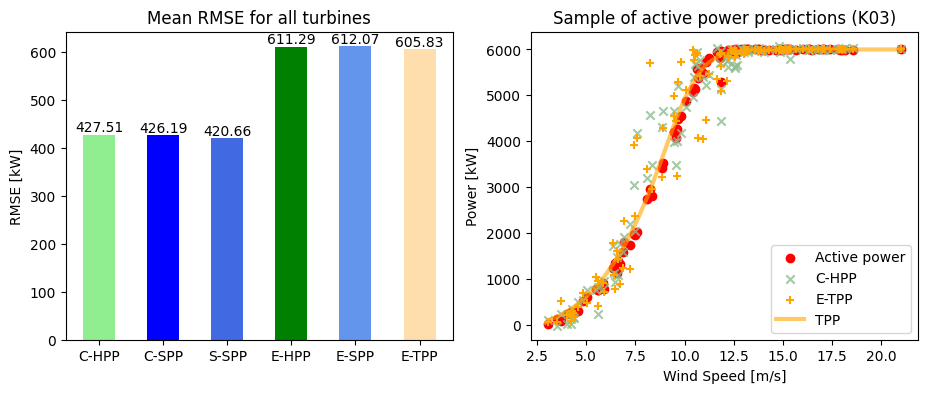

In [80]:

theo_rmse_mean = pd.DataFrame(rmse_theoretical, index=[0]).mean(axis=1)[0]

coupled_hybrid_rmse_mean = pd.DataFrame(rmse_c_hybrid, index=[0]).mean(axis=1)[0]
coupled_standard_rmse_mean = pd.DataFrame(rmse_c_standard, index=[0]).mean(axis=1)[0]
estimated_hybrid_rmse_mean = pd.DataFrame(rmse_e_hybrid, index=[0]).mean(axis=1)[0]
estimated_standard_rmse_mean = pd.DataFrame(rmse_e_standard, index=[0]).mean(axis=1)[0]
estimated_theoretical_rmse_mean = pd.DataFrame(rmse_e_theoretical, index=[0]).mean(axis=1)[0]
solo_standard_rmse_mean = pd.DataFrame(rmse_s_standard, index=[0]).mean(axis=1)[0]



plt.rcParams["figure.figsize"] = (11, 4)
tt = 'K03'
topn = 100
ws = test_data[tt]['WindSpeed'].head(topn)
labels = test_data[tt][label].head(topn)
fig, axs = plt.subplots(1, 2)
axs[1].scatter(ws, labels, color = 'red', label='Active power')
axs[1].scatter(ws, coupled_hybrid_predictions[tt][:topn], marker='x', color='darkseagreen', alpha=0.8, label= 'C-HPP')
axs[1].scatter(ws, estimated_theoretical_predictions[tt][:topn], marker='+', color='orange', alpha=1, label= 'E-TPP')
axs[1].plot(ws.sort_values(), SWT6.power_ct(ws.sort_values())[0]/1000, linewidth=3, color='orange', alpha=0.6, label= 'TPP')

axs[1].legend()
axs[1].set_xlabel('Wind Speed [m/s]')
axs[1].set_ylabel('Power [kW]')
axs[1].set_title(f'Sample of active power predictions ({tt})')

labels = ['C-HPP','C-SPP', 'S-SPP', 'E-HPP', 'E-SPP', 'E-TPP']
values = [coupled_hybrid_rmse_mean, coupled_standard_rmse_mean, solo_standard_rmse_mean,  estimated_hybrid_rmse_mean, estimated_standard_rmse_mean ,estimated_theoretical_rmse_mean]
colors = ['lightgreen','blue', 'royalblue', 'green', 'cornflowerblue', 'navajowhite']
bars = axs[0].bar(labels, values, width=0.5, color=colors)

axs[0].set_title('Mean RMSE for all turbines')

axs[0].set_ylabel('RMSE [kW]')

for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom', 
             fontsize=10, color='black', ha='center') 


1.1374070731493147


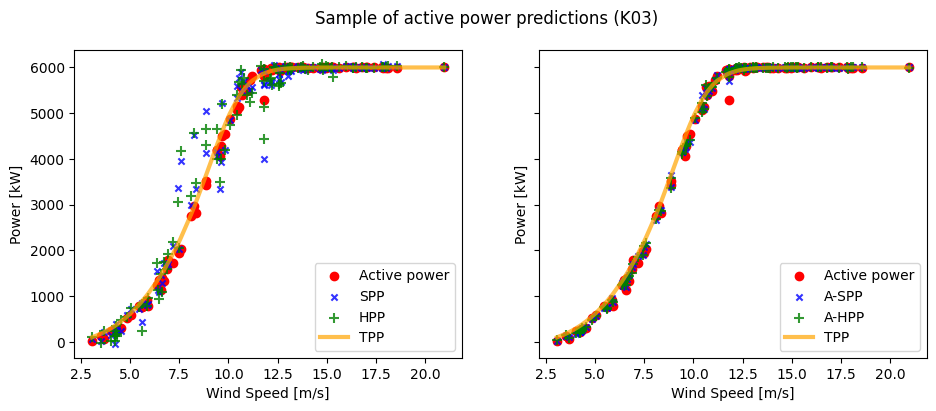

In [79]:
plt.rcParams["figure.figsize"] = (11, 4)
tt = 'K03'
topn = 100
ws = test_data[tt]['WindSpeed'].head(topn)
labels = test_data[tt][label].head(topn)
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].scatter(ws, labels, color = 'red', label='Active power')
axs[0].scatter(ws, coupled_standard_predictions[tt][:topn], marker='x', color = 'blue', alpha=0.8,s=20, label= 'SPP')
axs[0].scatter(ws, coupled_hybrid_predictions[tt][:topn], marker='+', s=60, color='green', alpha=0.8, label= 'HPP')
axs[0].plot(ws.sort_values(), SWT6.power_ct(ws.sort_values())[0]/1000, linewidth=3, color='orange', alpha=0.7, label= 'TPP')

axs[0].legend()
axs[0].set_xlabel('Wind Speed [m/s]')
axs[0].set_ylabel('Power [kW]')
#axs[0].set_title(f'Sample of active power predictions ({tt})')


axs[1].scatter(ws, labels, color = 'red', label='Active power')
axs[1].scatter(ws, ambient_standard_predictions[tt][:topn], marker='x', color = 'blue', alpha=0.8,s=20, label= 'A-SPP')
axs[1].scatter(ws, ambient_hybrid_predictions[tt][:topn], marker='+', s=60, color='green', alpha=0.8, label= 'A-HPP')
axs[1].plot(ws.sort_values(), SWT6.power_ct(ws.sort_values())[0]/1000, linewidth=3, color='orange', alpha=0.7, label= 'TPP')

axs[1].legend()
axs[1].set_xlabel('Wind Speed [m/s]')
axs[1].set_ylabel('Power [kW]')
#axs[1].set_title(f'Sample of active power predictions ({tt})')

print(np.mean(np.square(test_data[tt]['WindSpeed'].to_numpy() - test_data[tt]['WSE'].to_numpy())))

plt.suptitle(f'Sample of active power predictions ({tt})')

plt.show()